In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn import multiclass
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

# For plotting model
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Input,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers

from tensorflow.keras import utils
from tensorflow.keras import backend as K

import random

2023-09-20 17:51:47.446829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 17:51:48.279934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
np.random.seed(12)
random.seed(12)

In [3]:
# Using methods from other notebook
%run preprocessing_functions.ipynb

In [4]:
# Loading ck+ dataset
images, labels = load_data('datasets/ck+')

In [5]:
# As we see, this dataset consists of 327 images of 48 x 48 px
images.shape

(327, 48, 48)

In [6]:
K.image_data_format()

'channels_last'

In [7]:
img_rows = images.shape[1]
img_cols = images.shape[2]

In [8]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

In [9]:
# We don't want to normalize values because LBP preprocessing works better with values between 0 - 255
print(images[0])

[[36  8  2 ... 25 48 64]
 [12  3  2 ... 11 29 61]
 [ 4  2  1 ... 11 16 54]
 ...
 [68 68 67 ... 78 78 77]
 [68 68 69 ... 78 77 77]
 [66 67 69 ... 76 77 76]]


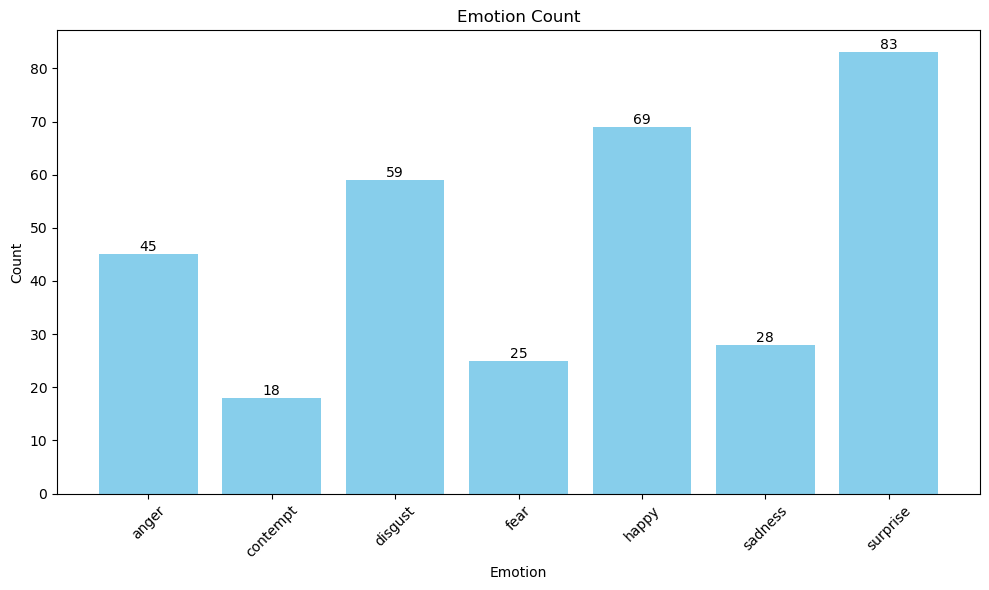

In [10]:
# We have unabalanced dataset, where emotion contempt has only 18 instances, while surprise have 83. One way to 
# balance this dataset is to create new instances of smaller classes

plot_count(images, labels)

In [11]:
# One possible way to make more data is to add mirrored images of faces, the face will still represent same emotion
# but we'll have somewhere different image

images, labels = add_mirror_images(images, labels, ["anger", "surprise", "disgust", "happy"])

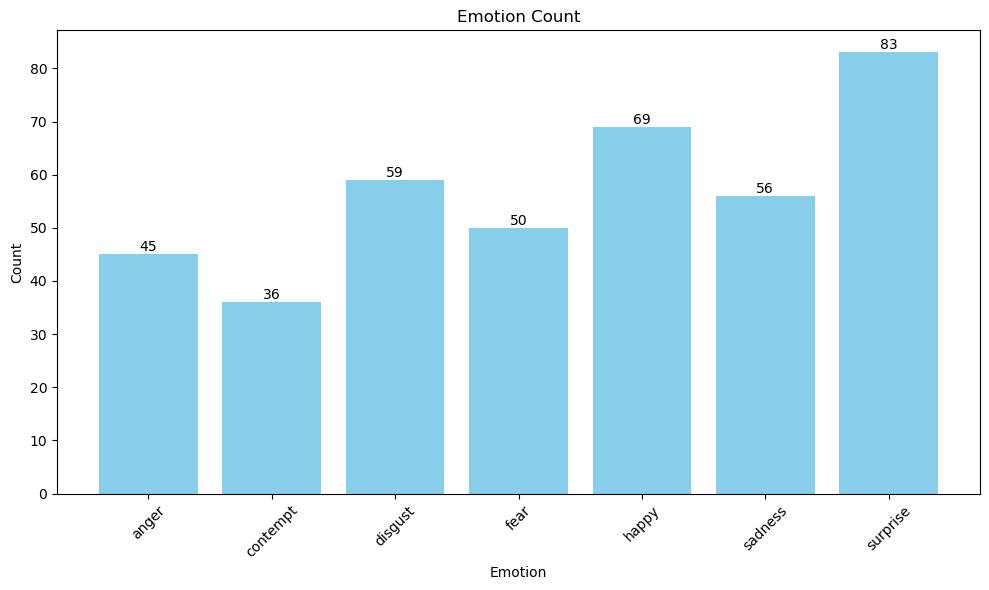

In [12]:
# We generated new instances, but the dataset is still unbalanced to some point because now we have classes with 
# more instances than the rest

plot_count(images, labels)

In [13]:
# One way to fix this is to randomly delete some of the instances from these classes
seed = 12
images, labels = random_delete_upto(images, labels, "disgust", 55, seed)
images, labels = random_delete_upto(images, labels, "happy", 55, seed)
images, labels = random_delete_upto(images, labels, "sadness", 55, seed)
images, labels = random_delete_upto(images, labels, "surprise", 55, seed)

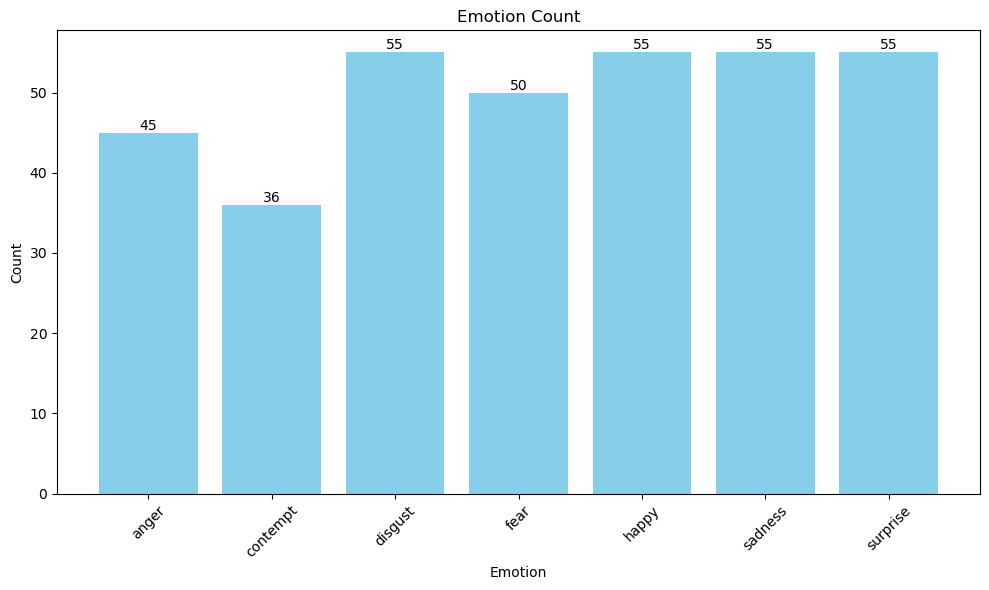

In [14]:
# Now the dataset looks more balanced

plot_count(images, labels)

In [15]:
images.shape

(351, 48, 48)

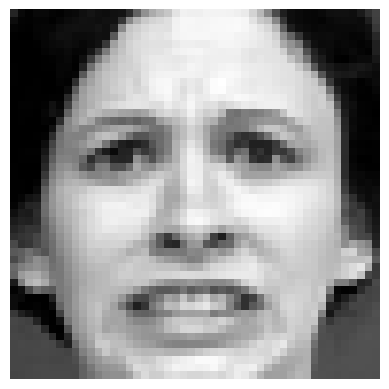

fear


In [16]:
plot_image(images[0], labels[0])

In [17]:
# Splitting the dataset into train and test set

train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=12, stratify=labels)

In [18]:
print('Train size: ',  len(train_data))
print('Test size: ',  len(test_data))

Train size:  245
Test size:  106


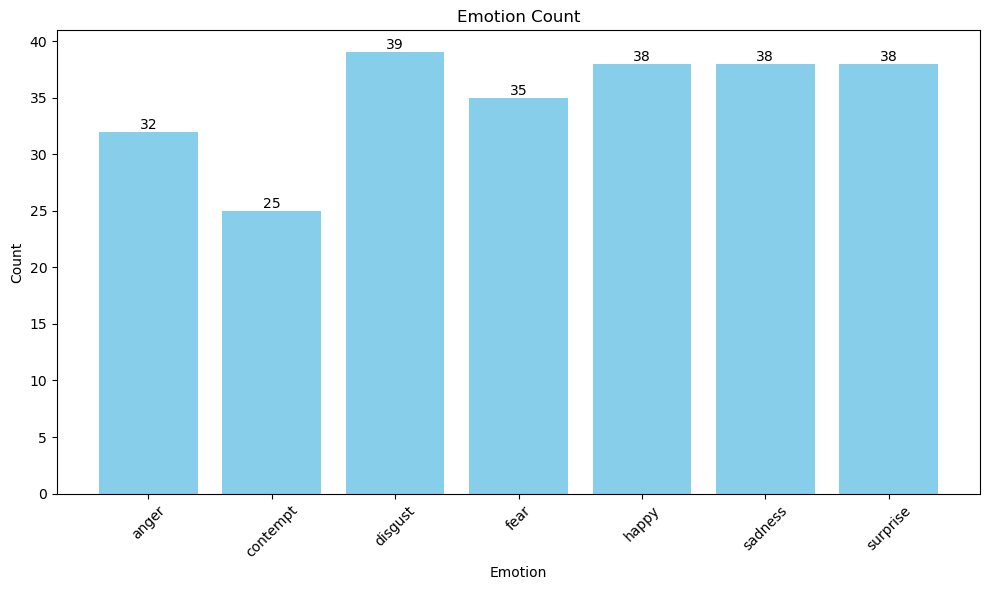

In [19]:
plot_count(train_data, train_labels)

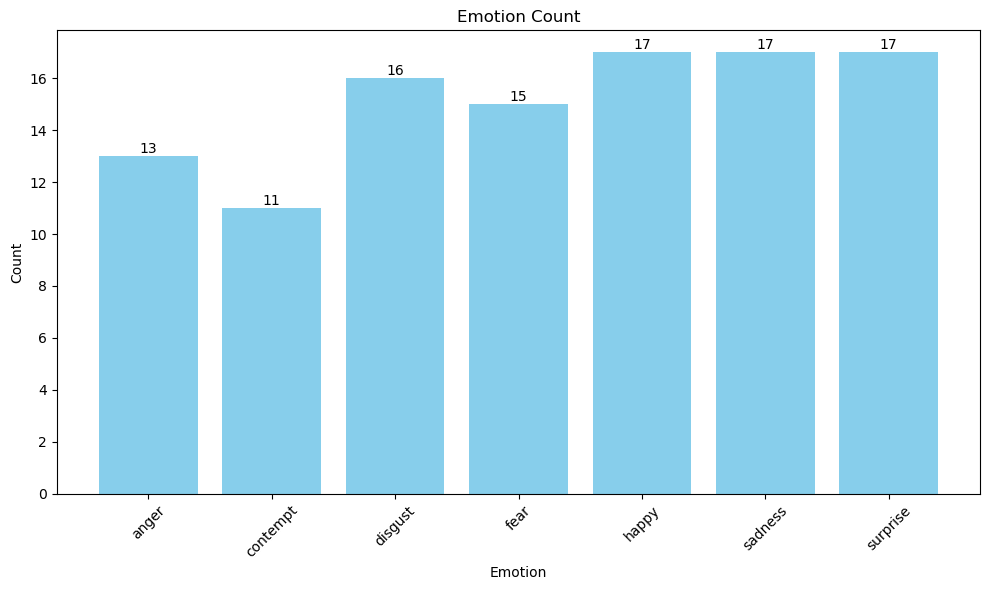

In [20]:
plot_count(test_data, test_labels)

In [21]:
train_data[0]

array([[75, 75, 88, ...,  1, 19, 21],
       [77, 78, 75, ...,  0, 12, 25],
       [79, 71, 55, ...,  0,  0,  5],
       ...,
       [ 0,  1,  4, ...,  2, 21, 32],
       [ 3,  2,  3, ...,  0,  8, 26],
       [ 1,  3, 14, ...,  0,  1,  1]], dtype=uint8)

In [22]:
train_data.shape

(245, 48, 48)

First approach is to use convolutional neural networks in order to classify our images

In [24]:
# First, we need to normalize our data

norm_train_data = train_data.astype('float32')
norm_train_data /= 255

norm_test_data = test_data.astype('float32')
norm_test_data /= 255

In [25]:
# Second, we want to one-hot code our target variable

number_of_classes = 7

# Create a dictionary to map unique string labels to unique integers
label_to_int = {label: idx for idx, label in enumerate(set(labels))}
int_to_label = {idx: label for label, idx in label_to_int.items()}

# Use the dictionary to convert your string labels to integer labels
train_labels_int = [label_to_int[label] for label in train_labels]
test_labels_int = [label_to_int[label] for label in test_labels]

cat_train_labels = utils.to_categorical(train_labels_int, number_of_classes)
cat_test_labels = utils.to_categorical(test_labels_int, number_of_classes)

In [26]:
# Function which returns CNN model

def create_cnn_model(num_conv_layers=2, num_dense_layers=2, dropout_rate = 0.4):

    model = Sequential()
    
    # Add convolutional layers
    for i in range(num_conv_layers):
        model.add(Conv2D(filters=16*(i+1), kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        if (random.uniform(0,1) < 0.8/(i+1)):
            model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    # Add dense layers with dropout
    for i in range(num_dense_layers):
        model.add(Dense(128, activation='relu'))
        if (random.uniform(0,1) < 0.8/(i+1)):
            model.add(Dropout(dropout_rate*((i+1)/2)))
    
    model.add(Dense(number_of_classes, activation='softmax'))
    
    model.compile(loss=CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
    
    return model

In [27]:
epochs = 30
batch_size = 32

In [28]:
cnn_params = {
    'num_conv_layers': [2, 3, 4],  
    'num_dense_layers': [1, 2],   
    'dropout_rate': [0.2, 0.5]    
}

In [29]:
best_accuracy = 0
best_params = {}
best_model = None
best_history = None

i = 0
# Iterate through hyperparameters
for num_conv_layers in cnn_params['num_conv_layers']:
    for num_dense_layers in cnn_params['num_dense_layers']:
        for dropout_rate in cnn_params['dropout_rate']:
            print("Testing model ", i)
            i += 1
            
            # Build and train model with the current hyperparameters
            model = create_cnn_model(num_conv_layers=num_conv_layers, num_dense_layers=num_dense_layers, dropout_rate=dropout_rate)
            history = model.fit(norm_train_data, cat_train_labels, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2)
        
            # Check if this model is better than the best so far
            if history.history['accuracy'][-1] > best_accuracy:
                best_accuracy = history.history['accuracy'][-1]
                best_params = {'num_conv_layers': num_conv_layers, 
                               'num_dense_layers': num_dense_layers,
                               'dropout_rate': dropout_rate}
                best_model = model
                best_history = history

print("Best accuracy:", best_accuracy)
print("Best hyperparameters:", best_params)

Testing model  0


2023-09-20 17:51:50.311989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Testing model  1
Testing model  2
Testing model  3
Testing model  4
Testing model  5
Testing model  6
Testing model  7
Testing model  8
Testing model  9
Testing model  10
Testing model  11
Best accuracy: 1.0
Best hyperparameters: {'num_conv_layers': 3, 'num_dense_layers': 1, 'dropout_rate': 0.2}


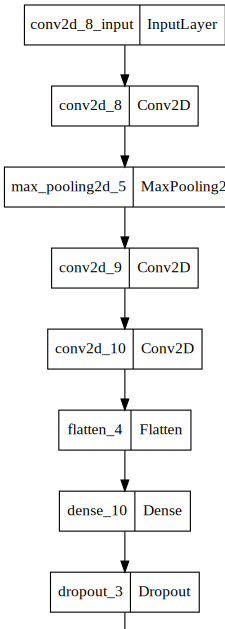

In [30]:
# Let's see our model

display(SVG(model_to_dot(best_model, dpi=65).create(prog='dot', format='svg')))

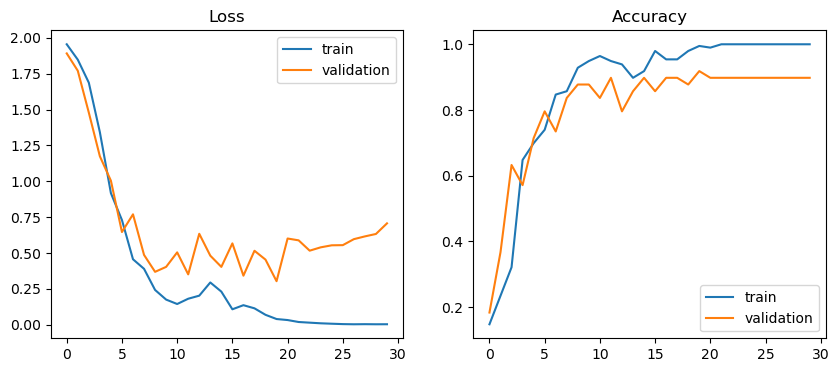

In [31]:
plot_history(best_history, epochs)

In [32]:
y_predictions = best_model.predict(norm_test_data)
pred_labels = [ int_to_label[np.argmax(y_predictions[i])] for i in range(len(y_predictions)) ]

4/4 [==============================] - 0s 8ms/step


In [33]:
generate_report(test_labels, pred_labels)

Confusion matrix: 
 [[ 9  0  1  0  0  1  2]
 [ 0  9  0  0  0  1  1]
 [ 0  0 16  0  0  0  0]
 [ 1  0  0 10  2  0  2]
 [ 0  0  0  1 16  0  0]
 [ 1  0  1  0  0 15  0]
 [ 0  0  0  0  0  0 17]] 
F1 score: 
 0.8642514625588987 
Accuracy: 
 0.8679245283018868 
Classification report: 
               precision    recall  f1-score   support

       anger       0.82      0.69      0.75        13
    contempt       1.00      0.82      0.90        11
     disgust       0.89      1.00      0.94        16
        fear       0.91      0.67      0.77        15
       happy       0.89      0.94      0.91        17
     sadness       0.88      0.88      0.88        17
    surprise       0.77      1.00      0.87        17

    accuracy                           0.87       106
   macro avg       0.88      0.86      0.86       106
weighted avg       0.87      0.87      0.86       106



Second approach is to extract some of the features from images. In order to do that, we'll use built-in function 
local_binary_pattern from feature library. After that, we can make different SVC or neural network models which 
will be used in our classification problem.

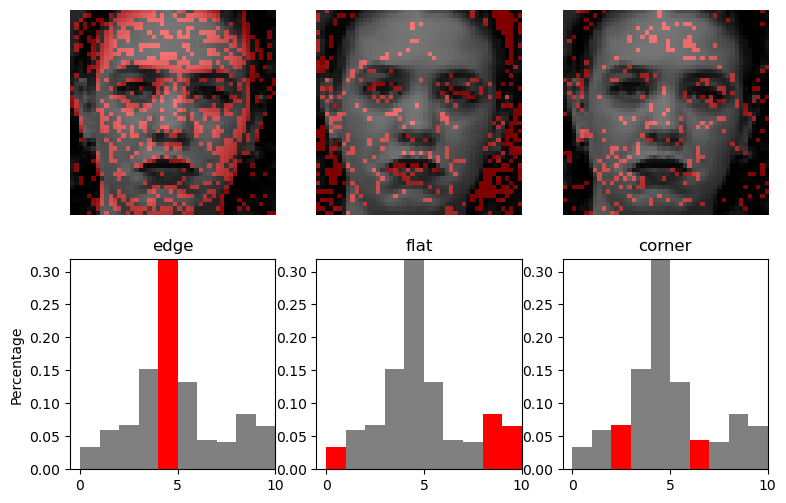

In [34]:
# For showing how lbp works

# Firstly, with radius 1 

plot_lbp_example(train_data[0], 1)

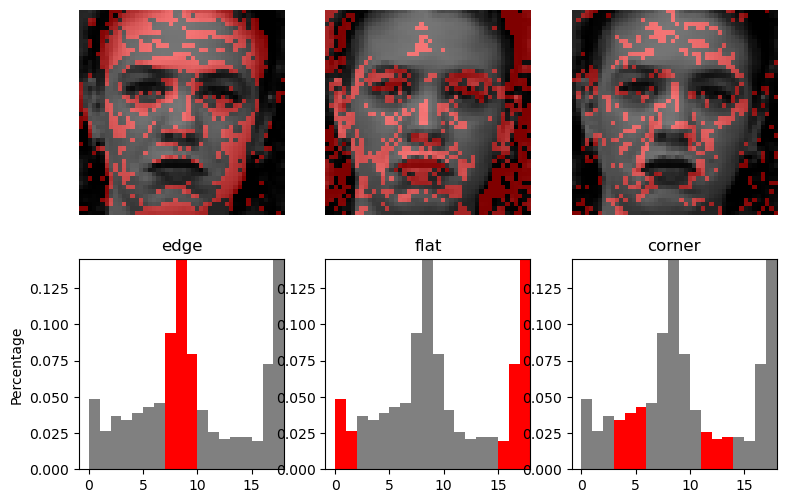

In [35]:
# With radius 2

plot_lbp_example(train_data[0], 2)

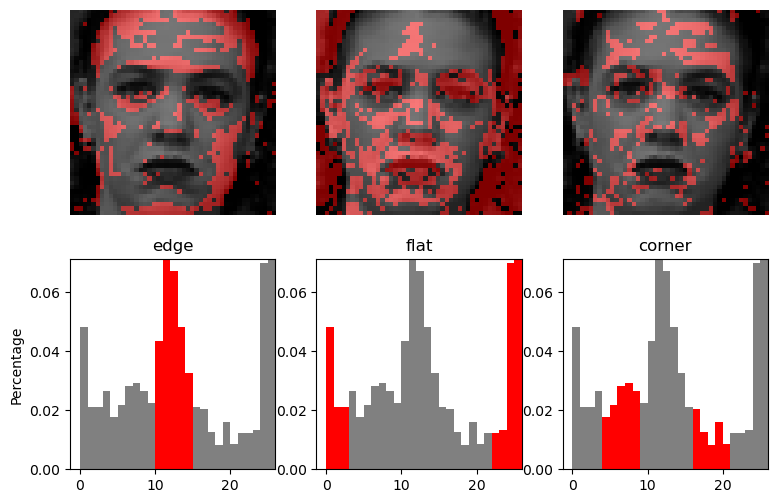

In [36]:
# With radius 3

plot_lbp_example(train_data[0], 3)

In [37]:
# Extracting lbp features from images

train_lbp_features = []
for image in train_data:
    lbp_feature = compute_lbp(image, 3, 555)
    train_lbp_features.append(lbp_feature)


test_lbp_features = []
for image in test_data:
    lbp_feature = compute_lbp(image, 3, 555)
    test_lbp_features.append(lbp_feature)

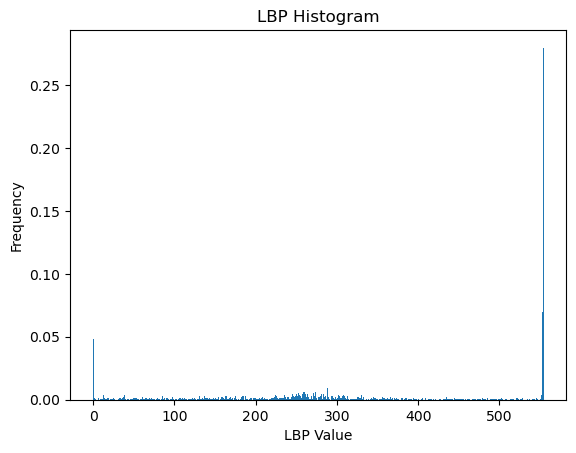

In [38]:
plot_lbp_hist(train_lbp_features[0])

In [39]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform LBP features
scaler.fit(train_lbp_features)
standardized_train_data = scaler.transform(train_lbp_features)
standardized_test_data = scaler.transform(test_lbp_features)

In [40]:
# Look for best CSV configuration

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
c = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4,1e5]
gammas = [0.01, 0.1, 1, 10, 100]

clf = svm.SVC()
clf.fit(standardized_train_data, train_labels)
param_grid = dict(kernel=kernels, C=c, gamma=gammas)

# GridSearchCV accepts dictionary with different hyper-parameters we want to try on the SVM model. 
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)

grid.fit(standardized_train_data, train_labels)
print(grid.best_params_)

{'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}


In [41]:
best_c = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']
best_kernel = grid.best_params_['kernel']

In [42]:
model = svm.SVC(kernel=best_kernel, gamma=best_gamma, C=best_c)

model.fit(standardized_train_data, train_labels)

pred_labels = model.predict(standardized_test_data)

generate_report(test_labels, pred_labels)

Confusion matrix: 
 [[ 8  0  0  1  1  1  2]
 [ 1  2  0  2  4  1  1]
 [ 5  0  9  0  2  0  0]
 [ 2  1  1  7  2  0  2]
 [ 1  0  1  1 13  0  1]
 [ 2  1  2  2  0 10  0]
 [ 0  0  2  0  1  2 12]] 
F1 score: 
 0.5650805727038228 
Accuracy: 
 0.5754716981132075 
Classification report: 
               precision    recall  f1-score   support

       anger       0.42      0.62      0.50        13
    contempt       0.50      0.18      0.27        11
     disgust       0.60      0.56      0.58        16
        fear       0.54      0.47      0.50        15
       happy       0.57      0.76      0.65        17
     sadness       0.71      0.59      0.65        17
    surprise       0.67      0.71      0.69        17

    accuracy                           0.58       106
   macro avg       0.57      0.56      0.55       106
weighted avg       0.58      0.58      0.57       106



In [43]:
# Training neural network model

number_of_classes = len(set(labels))


# Create a dictionary to map unique string labels to unique integers
label_to_int = {label: idx for idx, label in enumerate(set(labels))}
int_to_label = {idx: label for label, idx in label_to_int.items()}

# Use the dictionary to convert your string labels to integer labels
train_labels_int = [label_to_int[label] for label in train_labels]
test_labels_int = [label_to_int[label] for label in test_labels]


y_train = keras.utils.to_categorical(train_labels_int, number_of_classes)
y_test = keras.utils.to_categorical(test_labels_int, number_of_classes)

In [44]:
model = Sequential([
    InputLayer(input_shape=((standardized_train_data.shape[1]))),
    Dense(units=32, activation='relu'), 
    Dropout(rate=0.6),
    Dense(units=16, activation='relu'),
    Dropout(rate=0.4),
    Dense(units=number_of_classes, activation='softmax')
])


In [45]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                17792     
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_32 (Dense)            (None, 7)                 119       
                                                                 
Total params: 18,439
Trainable params: 18,439
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [47]:
batch_size = 16
epochs = 30

In [48]:
history = model.fit(standardized_train_data, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/30
13/13 [==============================] - 1s 11ms/step - loss: 2.9642 - accuracy: 0.1480 - val_loss: 2.0647 - val_accuracy: 0.1224
Epoch 2/30
13/13 [==============================] - 0s 4ms/step - loss: 2.6466 - accuracy: 0.1684 - val_loss: 2.0030 - val_accuracy: 0.1429
Epoch 3/30
13/13 [==============================] - 0s 4ms/step - loss: 2.4091 - accuracy: 0.2041 - val_loss: 1.9473 - val_accuracy: 0.2041
Epoch 4/30
13/13 [==============================] - 0s 3ms/step - loss: 2.2666 - accuracy: 0.1888 - val_loss: 1.9039 - val_accuracy: 0.2857
Epoch 5/30
13/13 [==============================] - 0s 17ms/step - loss: 1.9780 - accuracy: 0.2653 - val_loss: 1.8681 - val_accuracy: 0.2857
Epoch 6/30
13/13 [==============================] - 0s 25ms/step - loss: 1.9470 - accuracy: 0.2806 - val_loss: 1.8423 - val_accuracy: 0.3265
Epoch 7/30
13/13 [==============================] - 0s 26ms/step - loss: 1.8199 - accuracy: 0.3163 - val_loss: 1.8267 - val_accuracy: 0.3469
Epoch 8/30
13/13

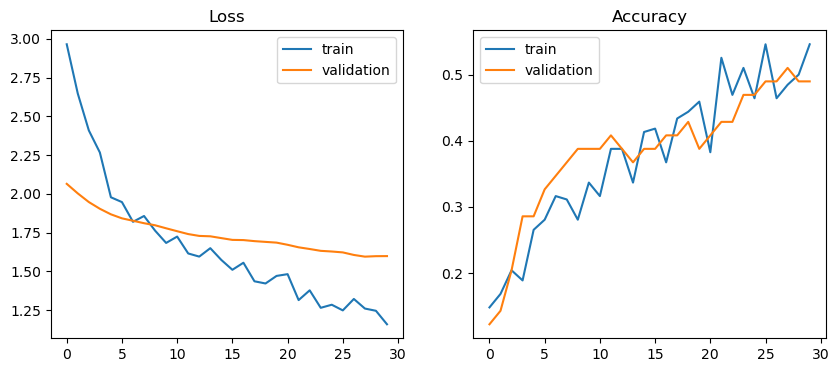

In [49]:
plot_history(history, epochs)

In [50]:
# As we see, the standard neural network needs to be regularized because we don't have a lot of data.
# Here we're trying different levels of regularization in order to find the best model

best_history = None
best_accuracy = 0
best_l = None
best_model = None

for l in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    regularizer = regularizers.l2(l=l)
    model_with_regularization = Sequential([
        InputLayer(input_shape=(standardized_train_data.shape[1])),
        Dense(units=32, activation='relu', kernel_regularizer=regularizer), 
        Dense(units=16, activation='relu', kernel_regularizer=regularizer),
        Dense(units=number_of_classes, activation='softmax')
    ])

    model_with_regularization.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    history_with_regularization = model_with_regularization.fit(standardized_train_data, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
    if history_with_regularization.history['accuracy'][-1] > best_accuracy:
        best_accuracy = history_with_regularization.history['accuracy'][-1]
        best_history = history_with_regularization
        best_l = l
        best_model = model_with_regularization

Epoch 1/30
13/13 [==============================] - 1s 11ms/step - loss: 10.3480 - accuracy: 0.1224 - val_loss: 9.8696 - val_accuracy: 0.1020
Epoch 2/30
13/13 [==============================] - 0s 4ms/step - loss: 8.7693 - accuracy: 0.2857 - val_loss: 8.7691 - val_accuracy: 0.1020
Epoch 3/30
13/13 [==============================] - 0s 4ms/step - loss: 7.6168 - accuracy: 0.4439 - val_loss: 7.8123 - val_accuracy: 0.1429
Epoch 4/30
13/13 [==============================] - 0s 4ms/step - loss: 6.6818 - accuracy: 0.5561 - val_loss: 6.9692 - val_accuracy: 0.1429
Epoch 5/30
13/13 [==============================] - 0s 3ms/step - loss: 5.8708 - accuracy: 0.6582 - val_loss: 6.2418 - val_accuracy: 0.1429
Epoch 6/30
13/13 [==============================] - 0s 4ms/step - loss: 5.1756 - accuracy: 0.7653 - val_loss: 5.6125 - val_accuracy: 0.1020
Epoch 7/30
13/13 [==============================] - 0s 4ms/step - loss: 4.5888 - accuracy: 0.8010 - val_loss: 5.0673 - val_accuracy: 0.1224
Epoch 8/30
13/13 [

13/13 [==============================] - 0s 4ms/step - loss: 2.3143 - accuracy: 0.6939 - val_loss: 2.4819 - val_accuracy: 0.3265
Epoch 28/30
13/13 [==============================] - 0s 4ms/step - loss: 2.2510 - accuracy: 0.6939 - val_loss: 2.4304 - val_accuracy: 0.3061
Epoch 29/30
13/13 [==============================] - 0s 3ms/step - loss: 2.1961 - accuracy: 0.6786 - val_loss: 2.3736 - val_accuracy: 0.3469
Epoch 30/30
13/13 [==============================] - 0s 4ms/step - loss: 2.1527 - accuracy: 0.6531 - val_loss: 2.3305 - val_accuracy: 0.2857
Epoch 1/30
13/13 [==============================] - 1s 13ms/step - loss: 67.4755 - accuracy: 0.1071 - val_loss: 56.7821 - val_accuracy: 0.1633
Epoch 2/30
13/13 [==============================] - 0s 3ms/step - loss: 49.8747 - accuracy: 0.1327 - val_loss: 42.0167 - val_accuracy: 0.1837
Epoch 3/30
13/13 [==============================] - 0s 4ms/step - loss: 36.9569 - accuracy: 0.1939 - val_loss: 31.4115 - val_accuracy: 0.2245
Epoch 4/30
13/13 [===

13/13 [==============================] - 0s 3ms/step - loss: 2.9975 - accuracy: 0.6071 - val_loss: 2.9906 - val_accuracy: 0.2449
Epoch 26/30
13/13 [==============================] - 0s 3ms/step - loss: 2.8505 - accuracy: 0.5714 - val_loss: 2.8517 - val_accuracy: 0.2041
Epoch 27/30
13/13 [==============================] - 0s 3ms/step - loss: 2.7224 - accuracy: 0.5357 - val_loss: 2.7270 - val_accuracy: 0.2041
Epoch 28/30
13/13 [==============================] - 0s 3ms/step - loss: 2.6113 - accuracy: 0.5306 - val_loss: 2.6205 - val_accuracy: 0.2245
Epoch 29/30
13/13 [==============================] - 0s 3ms/step - loss: 2.5166 - accuracy: 0.4898 - val_loss: 2.5288 - val_accuracy: 0.2245
Epoch 30/30
13/13 [==============================] - 0s 3ms/step - loss: 2.4340 - accuracy: 0.4745 - val_loss: 2.4505 - val_accuracy: 0.2245


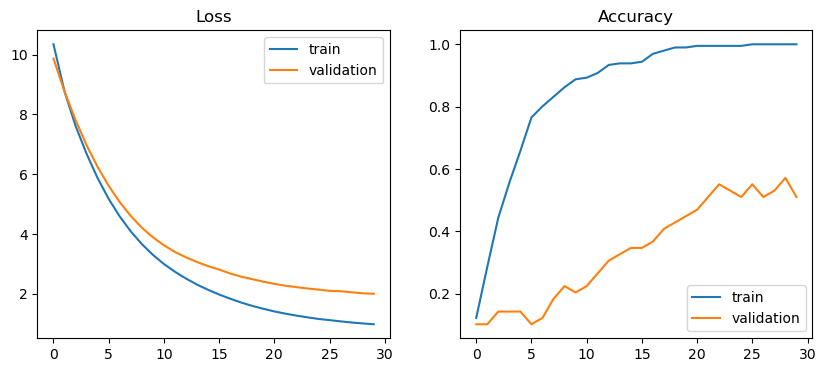

best l:  1.1


In [51]:
plot_history(best_history, epochs)
print("best l: ", l)

In [52]:
y_predictions = best_model.predict(standardized_test_data)
pred_labels = [ int_to_label[np.argmax(y_predictions[i])] for i in range(len(y_predictions)) ]

4/4 [==============================] - 0s 2ms/step


In [53]:
generate_report(test_labels, pred_labels)

Confusion matrix: 
 [[ 4  1  4  1  1  1  1]
 [ 0  3  3  1  3  1  0]
 [ 3  0 11  0  1  0  1]
 [ 0  2  1  6  3  1  2]
 [ 0  3  0  1 12  0  1]
 [ 1  2  3  3  0  8  0]
 [ 0  0  3  1  0  1 12]] 
F1 score: 
 0.5223835434572219 
Accuracy: 
 0.5283018867924528 
Classification report: 
               precision    recall  f1-score   support

       anger       0.50      0.31      0.38        13
    contempt       0.27      0.27      0.27        11
     disgust       0.44      0.69      0.54        16
        fear       0.46      0.40      0.43        15
       happy       0.60      0.71      0.65        17
     sadness       0.67      0.47      0.55        17
    surprise       0.71      0.71      0.71        17

    accuracy                           0.53       106
   macro avg       0.52      0.51      0.50       106
weighted avg       0.54      0.53      0.52       106



In [54]:
# Here we can see that even neural networks can't perform well because we don't have a lot of data